### Model cost/watt as function of three features: time (days), size (kilowatts), state

Add categorical feature state to model (cost ~ days, size, state(C)) 

Best parameters: {'features__num_vars__poly__degree': 14}, Best R squared: 0.534019834043528

#### Summary of results

OLS is better able to capture the trend of the data by including both _time_, _size_ and _state_ in the model (with a polynomial transformation). We did a 3-fold cross-validated test on the full dataset (364k rows) from polynomial degree 1 to degree 17 measuring  $R^2$  and the square root of the squared error (RMSE).

The 14th degree polynomial has the best fit (test $R^2$  = 0.534). At higher polynomials, the model overfits and test performance deteriorates. The validation curve for polynomial degree suggests that with regularization, we may be able to increase the model flexibility (increase polynomial degree) without overfitting and improve performance.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
dfModelAll.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
0,0.0,2.2824,CA,10.734315,0
1,21.0,1.8504,CA,11.108701,0
2,26.0,2.3076,CA,8.667013,0
3,84.0,2.3316,CA,13.270286,0
4,111.0,0.9300,CA,14.654839,0


In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


In [6]:
dfModelAll.state.unique()

[CA, OR, AZ, NY, MN, ..., MD, CT, FL, NM, AR]
Length: 19
Categories (19, object): [CA, OR, AZ, NY, ..., CT, FL, NM, AR]

#### Add state to the model

State is a categorical feature.  One standard method of including categorical variables is to encode them as a set of *n* columns that can the value 1 or 0 where *n* is the number of categories be encoded.  Only one of the variables (the one corresponding to the original category) will be 1; all the other new columns will contain 0.  This method is called one-hot encoding.

The encoding can be done in the pipeline, but Pandas provides a method for doing the job in one step.

### Shuffle dataset (and reduce if desired)

#### let's do the one hot encoding with pandas

In [7]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21); dfMod.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
201275,6205.0,5.400,AZ,3.652963,2
298480,6692.0,8.990,CA,1.112347,3
237778,6478.0,9.810,CA,4.719164,3
237823,6479.0,7.848,CA,4.799949,3
78485,4540.0,7.524,AZ,5.927698,3


In [8]:
dfMod = pd.get_dummies(dfMod, drop_first=True)

In [9]:
dfMod.head()

,num_days,size_kw,cost_per_watt,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,,,,,
201275,6205.0,5.400,3.652963,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298480,6692.0,8.990,1.112347,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237778,6478.0,9.810,4.719164,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237823,6479.0,7.848,4.799949,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78485,4540.0,7.524,5.927698,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### State is coded one-hot now, but how to do the polynomial transform in pipeline without including dummy vars?

I want a FeatureUnion to do polynomial expansion on num_days, size_kw, do nothing to the state columns.

In [10]:
theCols = dfMod.columns; theCols

Index(['num_days', 'size_kw', 'cost_per_watt', 'scaleSize', 'state_AZ',
       'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
       'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

#### Note: FeatureUnion transformation returns np.ndarray

#### Prep data for sklearn 

In [11]:
# for now work with small set
X = dfMod.drop(['cost_per_watt', 'scaleSize'], axis='columns')
y = dfMod[['cost_per_watt']]
X.shape, y.shape

((364212, 20), (364212, 1))

In [12]:
# take a look to make sure it's right.
X[:3]

,num_days,size_kw,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,,,
201275,6205.0,5.40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298480,6692.0,8.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237778,6478.0,9.81,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
            'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
            'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']

### Build a pipeline that does the right thing

* Take the data apart into numerical and dummy variables encoding $State$.
    * Numerical variables
        * scale
        * polynomial transform
    * Dummy variables
        * pass through
* Put polynomial transform back together with dummy variables for the regression

#### Make a transformer that can grab specified columns.

In [14]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

#### test ColumnExtractor

In [15]:
extractNumerical = ColumnExtractor(columns=['num_days', 'size_kw'])
extractNumerical.fit_transform(dfMod.head(3))            

,num_days,size_kw
row,,
201275,6205.0,5.40
298480,6692.0,8.99
237778,6478.0,9.81


In [16]:
extractDummies = ColumnExtractor(columns=theStates)
extractDummies.fit_transform(dfMod.head(3))            

,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,
201275,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237778,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# take the data apart; numerical vars get scaled, then go to polynomial; state dummies pass through; 
# they get glued back together for the regression.
testPipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    )]) # end of Pipeline

#### Test pipe without the regression

#### First make sure of the name of the parameter I want to use

In [18]:
testPipe.get_params()['features__num_vars__poly__degree']

2

In [19]:
testPipe.set_params(features__num_vars__poly__degree=1)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('num_vars', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=['num_days', 'size_kw'])), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False))])), ('cat_vars', Colu..., 'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']))],
       transformer_weights=None))])

In [20]:
testPipe.fit_transform(dfMod.head(3))

array([[ 1.    , -1.2711, -1.3924,  1.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  1.1724,  0.4821,  0.    ,  1.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  0.0987,  0.9103,  0.    ,  1.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])

#### Okay, this pipeline does what it should.  Now add the regression as the last step and grid_search_CV on the dataset.

In [21]:
# first, add LR to the pipeline
# take the data apart; numerical vars get scaled, then go to polynomial; state dummies pass through; 
# they get glued back together for the regression.
thePipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('LR', LinearRegression())
]) # end of Pipeline

In [22]:
# Specify the hyperparameter space.
poly_space = np.arange(1, 16)
# Create the hyperparameter grid, just poly degree up to 6th
param_grid = {'features__num_vars__poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(thePipe, param_grid, cv=3, return_train_score=True)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Best parameters: {'features__num_vars__poly__degree': 14}
test R squared: 0.5340198363990124


In [23]:
# this will show the results data structure
gs_cv.cv_results_

{'mean_fit_time': array([0.3863, 0.2794, 0.3282, 0.4194, 0.515 , 0.6862, 0.8135, 0.9896,
        1.2049, 1.4636, 1.8228, 2.1567, 2.5819, 3.0107, 3.623 ]),
 'std_fit_time': array([0.1914, 0.0081, 0.0053, 0.0219, 0.0112, 0.0277, 0.0182, 0.0291,
        0.0052, 0.0163, 0.0818, 0.0413, 0.0242, 0.0186, 0.2193]),
 'mean_score_time': array([0.0269, 0.0341, 0.0465, 0.0722, 0.1083, 0.1397, 0.1788, 0.234 ,
        0.2881, 0.3666, 0.4555, 0.5448, 0.7079, 0.8108, 1.0515]),
 'std_score_time': array([0.0013, 0.0033, 0.0025, 0.005 , 0.0114, 0.0161, 0.0009, 0.0127,
        0.0038, 0.0058, 0.0082, 0.0039, 0.064 , 0.0005, 0.1248]),
 'param_features__num_vars__poly__degree': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'features__num_vars__poly__degree': 1},
  {'features_

#### Now do multiple scoring so we can look at RMSE and $R^2$

In [24]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Specify the hyperparameter space.
poly_space = np.arange(1, 18)
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gs_cv
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

gs_cv = GridSearchCV(thePipe, param_grid, cv=3, 
                     scoring=scoring, return_train_score=True,
                     refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'features__num_vars__poly__degree': 14}
Best R squared: 0.5340198363990124


In [25]:
gs_cv.cv_results_

{'mean_fit_time': array([0.2677, 0.2764, 0.3727, 0.4923, 0.503 , 0.6511, 0.8723, 0.9963,
        1.2774, 1.4733, 1.7607, 2.1116, 2.5277, 3.0658, 3.503 , 4.6872,
        4.778 ]),
 'std_fit_time': array([0.0242, 0.0139, 0.0655, 0.0969, 0.0074, 0.0381, 0.1241, 0.0225,
        0.0726, 0.0066, 0.016 , 0.0073, 0.0352, 0.1046, 0.0206, 0.5186,
        0.1151]),
 'mean_score_time': array([0.0535, 0.0685, 0.108 , 0.1564, 0.1945, 0.2757, 0.3827, 0.4843,
        0.6778, 0.7697, 0.9007, 1.1271, 1.3462, 1.6116, 1.9007, 2.2315,
        2.5538]),
 'std_score_time': array([0.0021, 0.0055, 0.0098, 0.0265, 0.0043, 0.003 , 0.0126, 0.0116,
        0.1269, 0.0389, 0.0029, 0.0106, 0.0186, 0.0163, 0.0384, 0.0169,
        0.0307]),
 'param_features__num_vars__poly__degree': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, Fa

In [26]:
list(zip(gs_cv.cv_results_['param_features__num_vars__poly__degree'], 
         gs_cv.cv_results_['mean_test_Rsquared'], 
         np.abs(gs_cv.cv_results_['mean_test_RMSE'])))

[(1, 0.45792472651552485, 1.5839518465330997),
 (2, 0.4815558592390755, 1.5490385562512914),
 (3, 0.4990456030729419, 1.5226874355936992),
 (4, 0.5125313062068645, 1.502052687662885),
 (5, 0.5147435834044393, 1.4986405188371241),
 (6, 0.5250349799371739, 1.4826634794899582),
 (7, 0.525987976251486, 1.4811751003019085),
 (8, 0.5281763864070167, 1.4777515524647913),
 (9, 0.528670132338545, 1.4769784767043685),
 (10, 0.5294896254245042, 1.475694030663164),
 (11, 0.5301481152923729, 1.474660767998539),
 (12, 0.5307192656887935, 1.4737643085948344),
 (13, 0.5310110188986272, 1.4733064561200195),
 (14, 0.5313501222952657, 1.4727742024053319),
 (15, 0.5312008982641229, 1.4730095703262542),
 (16, 0.5313477383412376, 1.4727762115297047),
 (17, 0.5294613128776553, 1.4757402130142)]

Best parameters: {'features__num_vars__poly__degree': 14}
Best R squared: 0.5340198363990124


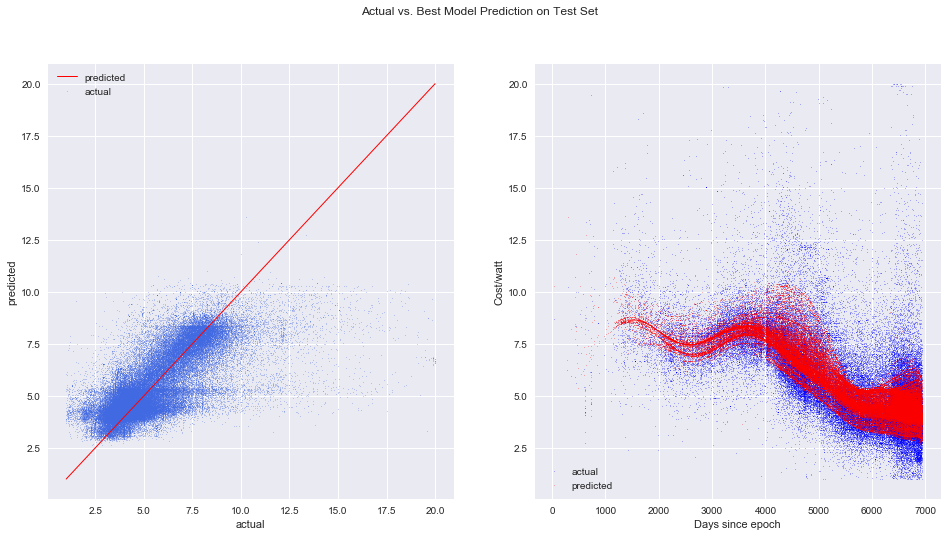

In [27]:
# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

prediction = gs_cv.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, prediction, marker='.', s=2, color='royalblue', alpha=0.3, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_xlabel('')
ax1.set_ylabel('predicted')
ax1.set_xlabel('actual')
ax1.legend()

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='blue', s=2, alpha=0.3, label='actual')
ax2.scatter(X_test.iloc[:, 0], prediction, marker='.', color='red', s=2, alpha=0.3, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Days since epoch')
ax2.legend()

plt.show();

In [28]:
def trainVsTestResults(results):
    ''' Plot test/train results for R^2 and RMSE'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', alpha=1, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_['features__num_vars__poly__degree']))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', alpha=1, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'features__num_vars__poly__degree': 14}
Best R squared: 0.5340198363990124


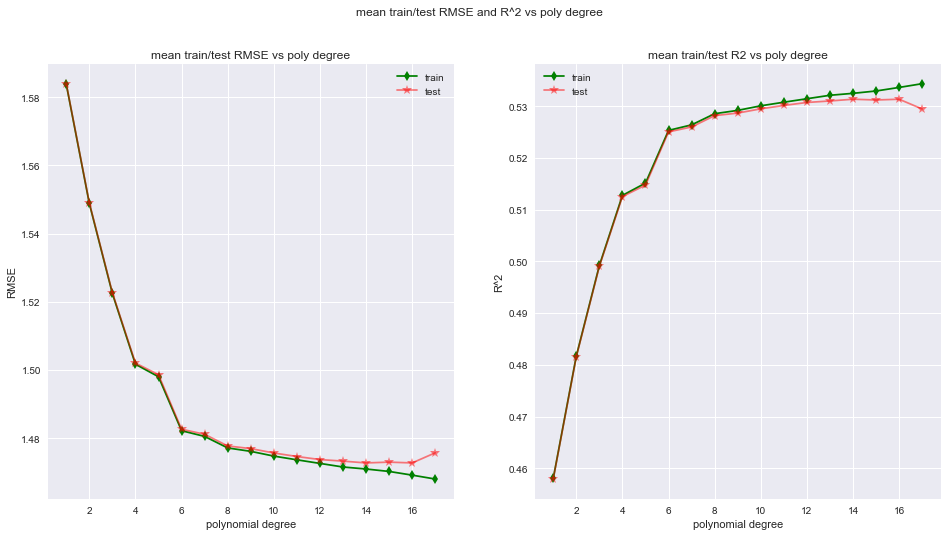

In [29]:
trainVsTestResults(gs_cv.cv_results_)

In [30]:
gs_cv.cv_results_

{'mean_fit_time': array([0.2677, 0.2764, 0.3727, 0.4923, 0.503 , 0.6511, 0.8723, 0.9963,
        1.2774, 1.4733, 1.7607, 2.1116, 2.5277, 3.0658, 3.503 , 4.6872,
        4.778 ]),
 'std_fit_time': array([0.0242, 0.0139, 0.0655, 0.0969, 0.0074, 0.0381, 0.1241, 0.0225,
        0.0726, 0.0066, 0.016 , 0.0073, 0.0352, 0.1046, 0.0206, 0.5186,
        0.1151]),
 'mean_score_time': array([0.0535, 0.0685, 0.108 , 0.1564, 0.1945, 0.2757, 0.3827, 0.4843,
        0.6778, 0.7697, 0.9007, 1.1271, 1.3462, 1.6116, 1.9007, 2.2315,
        2.5538]),
 'std_score_time': array([0.0021, 0.0055, 0.0098, 0.0265, 0.0043, 0.003 , 0.0126, 0.0116,
        0.1269, 0.0389, 0.0029, 0.0106, 0.0186, 0.0163, 0.0384, 0.0169,
        0.0307]),
 'param_features__num_vars__poly__degree': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, Fa

In [31]:
X.shape, y.shape

((364212, 20), (364212, 1))